# Homework 4: Conversation Modeling and decoding

# Part 1 Modeling

### Utilities

In [0]:
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import pickle as pkl
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

class ChatDictionary(object):

    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)


class ChatDataset(Dataset):

    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)


def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, 
                                                             input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [0]:
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'


In [0]:
class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

## 1.1 Attention visulization

In [0]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [0]:
def attn_map(att_w_log, inp_token, target_token):
    table = pd.DataFrame(np.array([w[0].tolist() for w in attn_w_log]).T)
    table.index = inp_token
    table.columns = target_token
    sns.set()
    plt.figure(figsize=(10,15))
    ax = sns.heatmap(table, vmin=0, vmax=1, cmap="Purples", cbar_kws={'label': 'Attention weight'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title('Attention Map')
    plt.show()
    print()

### You present here:

In [0]:
# this is some example attention map here, 
# *make sure you add text tokens on the axes to make it readable!*

![Imgur](https://i.imgur.com/xodciCU.png)

100%|██████████| 7801/7801 [00:00<00:00, 8929.75it/s]


Example 1
Input:
your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?

Target:
i am good , i just got off work and tired , i have two jobs . __end__



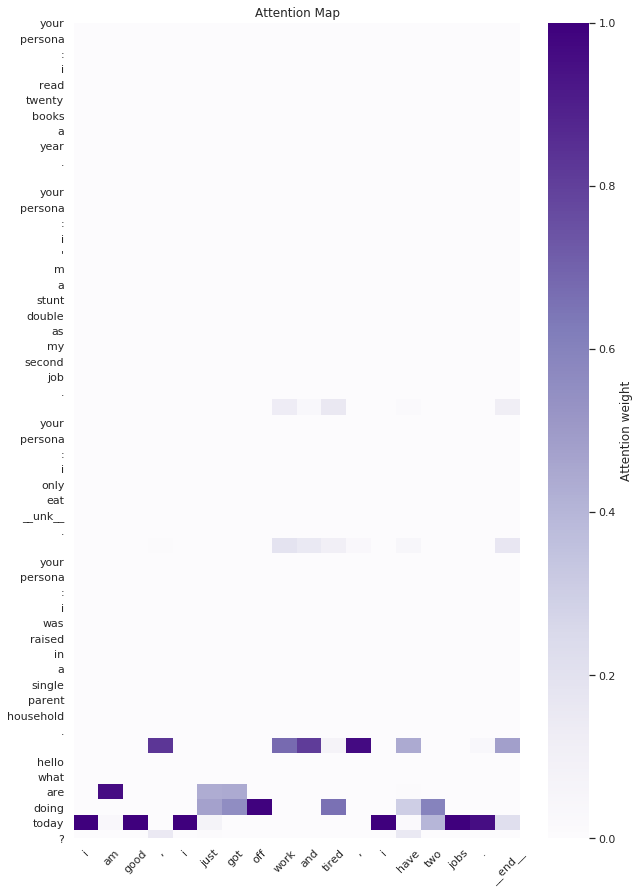


Example 2
Input:
your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ? 
 i am good , i just got off work and tired , i have two jobs . 
 i just got done watching a horror movie

Target:
i rather read , i ' ve read about 20 books this year . __end__



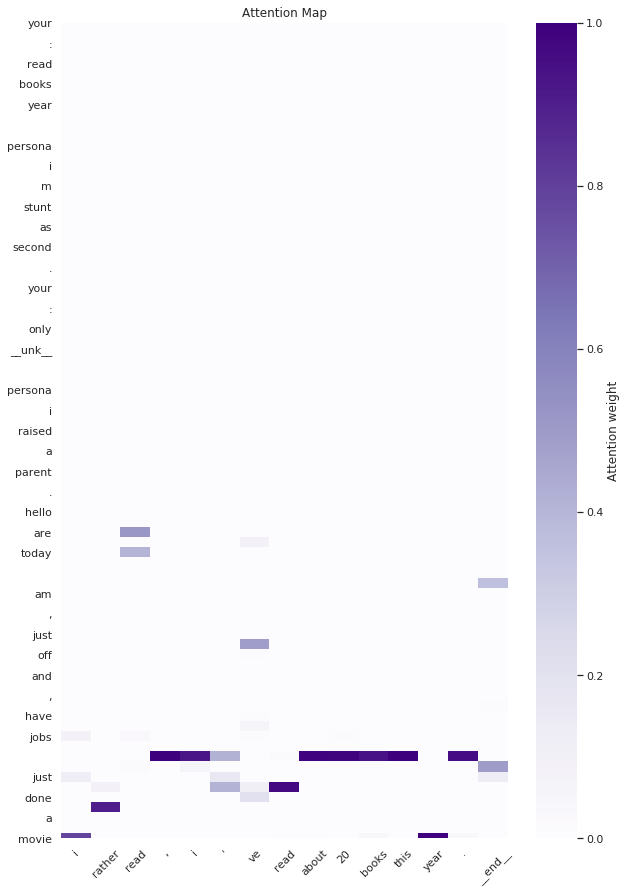


Example 3
Input:
your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ? 
 i am good , i just got off work and tired , i have two jobs . 
 i just got done watching a horror movie 
 i rather read , i ' ve read about 20 books this year . 
 wow ! i do love a good horror movie . loving this cooler weather

Target:
but a good movie is always good . __end__



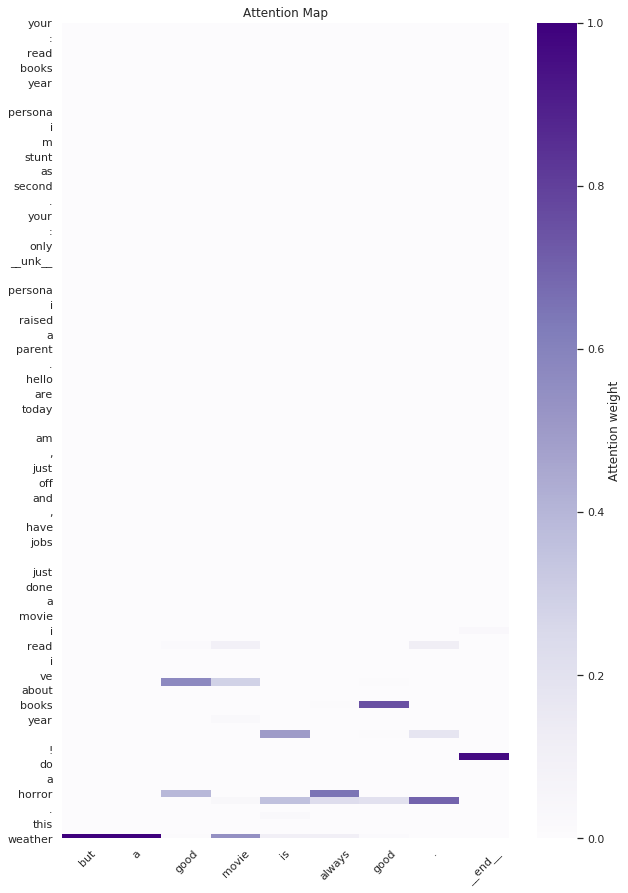


Example 4
Input:
your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ? 
 i am good , i just got off work and tired , i have two jobs . 
 i just got done watching a horror movie 
 i rather read , i ' ve read about 20 books this year . 
 wow ! i do love a good horror movie . loving this cooler weather 
 but a good movie is always good . 
 yes ! my son is in junior high and i just started letting him watch them too

Target:
i work in the movies as well . __end__



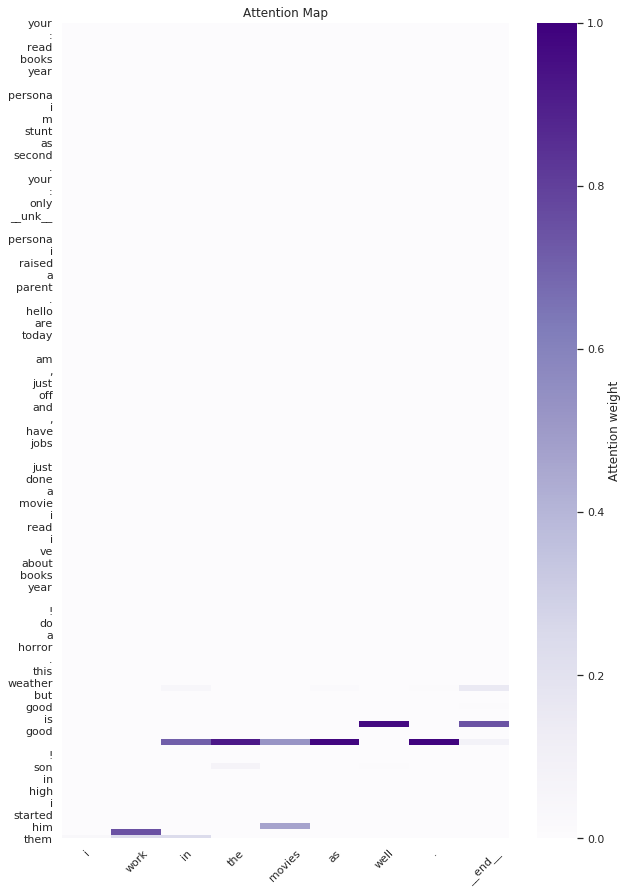


Example 5
Input:
your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ? 
 i am good , i just got off work and tired , i have two jobs . 
 i just got done watching a horror movie 
 i rather read , i ' ve read about 20 books this year . 
 wow ! i do love a good horror movie . loving this cooler weather 
 but a good movie is always good . 
 yes ! my son is in junior high and i just started letting him watch them too 
 i work in the movies as well . 
 neat ! ! i used to work in the human services field

Target:
yes it is neat , i stunt double , it is so much fun and hard work . __end__



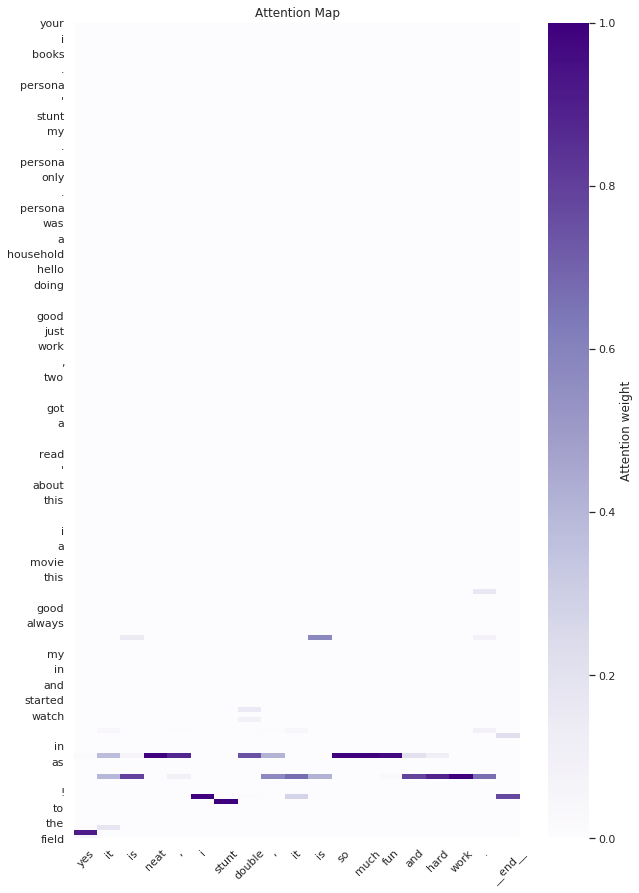

In [8]:
chat_dict = ChatDictionary('./dict')
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=1)
current_device = 'cpu'
model_pt = torch.load('chat_model_best_22.pt')
opts = model_pt['opts']
model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

count = 0
for batch in valid_loader:
    count += 1
    model.eval()      
    text_vecs = batch['text_vecs']
    target_vecs = batch['target_vecs']
    inp_token = [chat_dict.ind2word[i] for i in text_vecs[0].tolist()]
    target_token = [chat_dict.ind2word[i] for i in target_vecs[0].tolist()]
    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])   
    decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
    
    print('Example {}'.format(count))
    print('Input:\n' + ' '.join(inp_token) + '\n')
    print('Target:\n' + ' '.join(target_token) + '\n')
    attn_map(attn_w_log, inp_token, target_token)
 
    if count >= 5:
        break

## 1.2 Encoder Transformer

In [0]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch

class EncoderTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, nhead, dropout=0, shared_lt=None):
        super().__init__()
        # you need to add more things here
        if shared_lt is None:
            self.token_embed = nn.Embedding(vocab_size, embed_size, 0)
        else:
            self.token_embed = shared_lt
        self.position_embed = nn.Embedding(1000, embed_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=64, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, text_vec, text_lens, use_packed=True):
        text_lens = torch.Tensor(text_lens).to(text_vec.device)
        attention_mask = text_vec.ne(0)
        pos = torch.arange(len(text_vec), device=text_vec.device).unsqueeze(1)
        embed = self.token_embed(text_vec) + self.position_embed(pos)
        # if use_packed is True:
        #     embed = pack_padded_sequence(embed, text_lens, batch_first=True)
  
        output = self.transformer(embed)
        # if use_packed is True:
        #     output,_ = pad_packed_sequence(output, batch_first=True)

        return output, None, attention_mask

In [0]:
class seq2seq_2(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                  )
        
        self.encoder = EncoderTransformer(
                                            vocab_size=self.opts['vocab_size'],
                                            embed_size=self.opts['embedding_size'],
                                            num_layers=self.opts['num_layers_enc'],
                                            nhead = self.opts['nhead'],
                                            dropout=self.opts['dropout'],
                                            shared_lt=self.decoder.embedding
                                          )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

### You present here:

In [0]:
# check pdf to see what you expected to present

In [22]:
chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

100%|██████████| 7801/7801 [00:00<00:00, 13640.25it/s]


In [0]:
current_device = 'cuda'

opts = {}
opts['vocab_size'] = len(chat_dict)
opts['hidden_size'] = 256
opts['embedding_size'] = 256
opts['num_layers_enc'] = 2
opts['num_layers_dec'] = 1
opts['nhead'] = 4
opts['dropout'] = 0.1
opts['encoder_shared_lt'] = True

model = seq2seq_2(opts)
model.to(current_device)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [26]:
plot_cache = []
best_val_loss = 100

for epoch in range(10):    
    model.train()
    sum_loss = 0
    sum_tokens = 0
    
    for batch in tqdm(train_loader):
        optimizer.zero_grad()     
        text_vecs = batch['text_vecs'].to(current_device)
        target_vecs = batch['target_vecs'].to(current_device)
    
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])  
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        sum_loss += loss.item()
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        loss /= num_tokens
        
        sum_tokens += num_tokens
        
        loss.backward()
        optimizer.step()
        
    avg_train_loss = sum_loss/sum_tokens
    train_ppl = 2**(avg_train_loss/np.log(2))
    
    val_loss = 0
    val_tokens = 0
    for batch in valid_loader:
        model.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
        
    avg_val_loss = val_loss/val_tokens
    scheduler.step(avg_val_loss)
    val_ppl = 2**(avg_val_loss/np.log(2))   
    print("\nEpoch {} train loss = {} train ppl = {}".format(epoch+1, avg_train_loss, train_ppl))
    print("Epoch {} valid loss = {} Valid ppl = {}".format(epoch+1, avg_val_loss, val_ppl))
    print()
    plot_cache.append( (avg_train_loss, avg_val_loss) )
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        torch.save({
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
            }, f'./transformer_model_best_{epoch}.pt')

  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 1 train loss = 4.4940997707894415 train ppl = 89.48757338578814
Epoch 1 valid loss = 4.014485852244201 Valid ppl = 55.3948069638047



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 2 train loss = 3.795089979279557 train ppl = 44.482238705255796
Epoch 2 valid loss = 3.8336565442327233 Valid ppl = 46.231276253748796



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 3 train loss = 3.6246159950763164 train ppl = 37.51031624748748
Epoch 3 valid loss = 3.7731793895138295 Valid ppl = 43.518206445725674



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 4 train loss = 3.5205520896861735 train ppl = 33.80308564810333
Epoch 4 valid loss = 3.7581038238017794 Valid ppl = 42.867065357085764



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 5 train loss = 3.4426692312231344 train ppl = 31.270314570070582
Epoch 5 valid loss = 3.723644560789629 Valid ppl = 41.41505908845448



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 6 train loss = 3.3812642173309455 train ppl = 29.40792563189876
Epoch 6 valid loss = 3.716450047098255 Valid ppl = 41.11816715596827



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 7 train loss = 3.3294959190157933 train ppl = 27.924262065390625
Epoch 7 valid loss = 3.713336867641742 Valid ppl = 40.9903579723772



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 8 train loss = 3.2850702602670743 train ppl = 26.710860961184085
Epoch 8 valid loss = 3.71367369260679 Valid ppl = 41.004166873729346



  0%|          | 0/514 [00:00<?, ?it/s]


Epoch 9 train loss = 3.2477292142795546 train ppl = 25.731842024809893
Epoch 9 valid loss = 3.7268728584707196 Valid ppl = 41.548975272019256



100%|██████████| 514/514 [02:24<00:00,  3.66it/s]



Epoch 10 train loss = 3.212155505558682 train ppl = 24.832555288413662
Epoch 10 valid loss = 3.7293404309392746 Valid ppl = 41.65162697767208



# Part 2 Decoding

## 2.1 Nucleus Sampling

In [0]:
# implement nucleus sampling here.
# you must cite any code you use from other sources!

In [17]:
current_device = 'cuda'
model_pt = torch.load('./chat_model_best_22.pt')
opts = model_pt['opts']
model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=18760, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
  )
)

In [0]:
def nucleus_sampling(model, inp, p, current_device):
    model.eval()
    inp = inp.view(1,len(inp))
    batch = {
        'text_vecs': torch.tensor(inp, dtype=torch.long, device=model.decoder.embedding.weight.device),
        'text_lens': torch.tensor([len(inp[0])], dtype=torch.long),
        'use_packed': True
    }
    model.to(current_device)
    text_vecs = batch['text_vecs'].to(current_device)
    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    encoder_output, encoder_hidden, attention_mask = encoded
    decoder_hidden = encoder_hidden
    
    start = torch.Tensor([1]).long().to(current_device).expand(1, 1).long()  # expand to batch size
    pred = [int(start)]
    log_p = 0
    x = start
    for ts in range(100):
        decoder_output, decoder_hidden, attn_w_log = model.decoder(x, decoder_hidden, encoded)
        output = nn.Softmax(dim=2)(decoder_output)[0][-1]
        prob = torch.sort(output, descending=True)
        cut_index = 1
        while sum(prob[0][0:cut_index]) < p:
            cut_index += 1
        dist = prob[0][:cut_index] / sum(prob[0][:cut_index])
        sample = torch.multinomial(dist, 1)
        x = prob[1][sample].to(current_device).expand(1,1).long()
        
        pred.append(int(x))
        log_p += np.log2(float(output[x]))
        
        if int(x) == 2:
            break
            
    return pred, float(log_p)

### You present here:

In [0]:
# check pdf to see what you expected to present

In [20]:
inp = valid_dataset[0][0]
chat_dict.v2t(inp.tolist())

"your persona : i read twenty books a year . \n your persona : i ' m a stunt double as my second job . \n your persona : i only eat __unk__ . \n your persona : i was raised in a single parent household . \n hello what are doing today ?"

In [0]:
samples = [[],[],[]]
scores = [[],[],[]]
p_list = [0.1, 0.5, 0.9]
for i, p in enumerate(p_list):
    for t in range(100):
        pred, log_p = nucleus_sampling(model, inp, p, current_device)
        samples[i].append(chat_dict.v2t(pred))
        scores[i].append(log_p)

In [0]:
samples = pkl.load(open("samples_2_1.p", "rb"))
scores = pkl.load(open("scores_2_1.p", "rb"))

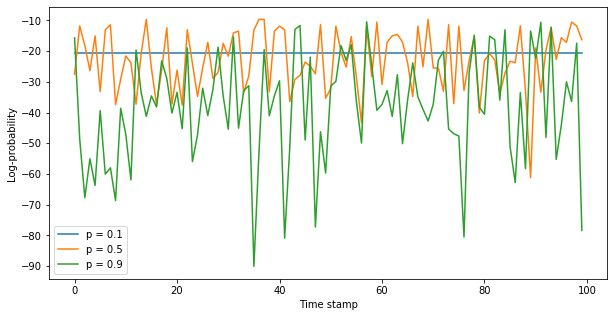

In [7]:
plt.figure(figsize=(10,5))
p_list = [0.1, 0.5, 0.9]
for i, p in enumerate(p_list):
    plt.plot(np.arange(100), scores[i], label='p = {}'.format(p))

plt.legend()
plt.xlabel('Time stamp')
plt.ylabel('Log-probability')
plt.show()

In [19]:
for i, p in enumerate(p_list):
    all_pred = RETOK.findall(' '.join(samples[i]))
    print('Samples for p = {} have {} unique tokens'.format(p, len(set(all_pred))))

Samples for p = 0.1 have 12 unique tokens
Samples for p = 0.5 have 120 unique tokens
Samples for p = 0.9 have 270 unique tokens


## 2.2 N-Gram blocking

In [0]:
# implement n-gram blocking
# carefully read instructions in pdf

# we give you some small hint code here which can be helpful

l = [1,2,3,4,5,6,4,5,6]

history = tuple(l[-2:])

print(history)

banned = []

for ngram in zip(*[l[i:] for i in range(3)]):
    if ngram[:-1] == history:
        banned.append(ngram[-1])
        
print(banned)

### You present here:

In [0]:
# check pdf to see what you expected to present

# Part 3 Interactive chat

In [0]:
# implement logic for interactive chat here
# the easiest is to just use python input functionality

### You present here:

In [0]:
# check pdf to see what you expected to present